In [3]:
import base64
import warnings
warnings.filterwarnings("ignore")

In [8]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'MIT Download')

In [9]:
print(len(messages))

36


In [10]:
# message = messages[2]
# msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
# content = msg['payload']['parts'][0]['body']['data']
# msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
# start_str = 'to get The Download every day.\r\n\r\n'
# content_str = msg_body[msg_body.find(start_str) + len(start_str):msg_body.find('We can still have nice things')]
# articles = content_str.split('------------------------------------------------------------')
# print(len(articles), articles[0])

In [11]:
import base64
import re
from tqdm import tqdm
import pandas as pd

def parse_main_reads(date, msg_body):
    """ Returns a list of article information"""
    
    start_str = 'to get The Download every day.\r\n\r\n'
    content_str = msg_body[msg_body.find(start_str) + len(start_str):msg_body.find('We can still have nice things')]
    content_str = re.sub(r"http\S+", "", content_str, flags=re.MULTILINE)
    content_str = re.sub(r" \( ", "", content_str, flags=re.MULTILINE)
    content_str = re.sub(r'\r\n', ' ', content_str, flags=re.MULTILINE)
    articles = content_str.split('------------------------------------------------------------')
    articles = [text[:text.find('Read the full story')] for text in articles]
    return articles

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def parse_must_reads(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    must_reads = msg_body[msg_body.index('The must-reads'):]
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE)
    text = deEmojify(text)
    articles = []
    for i in range(1, 11):
        try:
            articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*) \((.*) \r\n', text, re.MULTILINE)[0]))
        except:
            try:
                articles.append(list(re.findall('\n' + str(i) + ' (.*)\r\n(.*)\((.*) \r\n', text, re.MULTILINE)[0]))
            except:
                continue
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    if msg_body.find('The must-reads') != -1:
        fetched_articles = parse_must_reads(date, msg_body)
        for must_reads in fetched_articles:
            data.append([date, *must_reads])
    else:
        continue

100%|██████████| 36/36 [00:09<00:00,  3.74it/s]


In [40]:
!pip install demoji

     |████████████████████████████████| 41 kB 776 kB/s eta 0:00:011


In [43]:
import demoji
# demoji.findall(data[-1][1])
demoji.replace(data[-1][1], "")

'Bendable ice is a thing that exists '

In [14]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Source'])
df.to_csv('must_reads_MIT_download.csv', index=False)
df

,Date,Title,Subtitle,Source
0,2021-08-25 12:03:48+00:00,The coronavirus could get worse,We’re approaching an evolutionary tipping point.,Atlantic
1,2021-08-25 12:03:48+00:00,Vaccine immunity seems to wane after 6 months,But they’re still doing a good job.,BBC
2,2021-08-25 12:03:48+00:00,Inside Boston Dynamics’ plan to create useful ...,A look behind the viral video hype.,The Next Web
3,2021-08-25 12:03:48+00:00,A hidden Arctic cave holds secrets about our p...,"After half a century of wondering, we’re about...",Wired UK
4,2021-08-25 12:03:48+00:00,Waymo is expanding its driverless rides in San...,"But riders will have to sign an NDA, lol.",Verge
...,...,...,...,...
314,2021-07-12 12:07:58+00:00,How a ransomware attack works,"This breaks the anatomy of these hacks down, s...",WP
315,2021-07-12 12:07:58+00:00,Amazon is pulling brands from its store—and co...,There has to be a better way of dealing with i...,The Verge
316,2021-07-12 12:07:58+00:00,How to make working remotely work,"Out with surveillance and visible busyness, in...",New Yorker
317,2021-07-12 12:07:58+00:00,In defense of Twitter,"Yes, it can be awful. But it can be wonderful,...",FT


<AxesSubplot:>

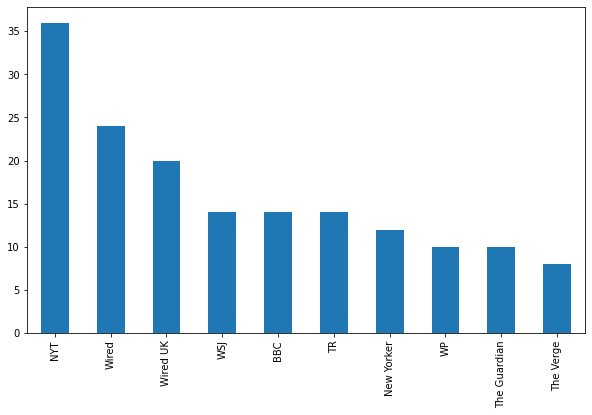

In [15]:
df['Source'].value_counts().iloc[:10].plot.bar(figsize=(10,6))

In [71]:
# Data Cleaning
import nltk
from nltk.stem import WordNetLemmatizer
import string

# concatenate title and subtitle columns
df['text'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)

# remove emojis
df['text'] = df['text'].apply(lambda x: demoji.replace(x, ""))

# remove punctuation
df['text'] = df['text'].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))

# remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not')
stopwords.remove('no')
df['text'] = df['text'].apply(lambda x: ' '.join([w.strip() for w in x.split() if w not in stopwords]))

# lemmatization
df['text'] = df['text'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

# remove short words
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w.strip()) >= 3]))

print(*df.tail(n=20).text.values, sep='\n')

Were inching closer breathalyzer covid tearinducing stick nose hopefully
Israel become first country approve third booster shot For immunocompromised adult
Englands soccer player racially abused online Truly awful
Drought stressing California’s power grid vital clean energy source running dry
The pandemic forcing rethink cause asthma attack Attacks plummeted last year suggests virus cold play much bigger role environmental factor
Whats best day office There onesizefitsall answer
Facebook want lure creator Good luck TikTok YouTube got first
Elon Musk rather hate running Tesla Well explains quite lot
Amazon want watch sleep thanks
Stop doomscrolling start gaming One way better mental health
How effective covid19 vaccine Delta variant Theyre keeping people hospital But clear good preventing infection transmission
How hot hot human body Things become much difficult 35°C around 95°F
Venture capitalist sight set online content creator specifically tool platform theyre using
Why grid finally 

In [72]:
df.tail(20)

,Date,Title,Subtitle,Source,combined,text
299,2021-07-13 12:07:42+00:00,We're inching closer to breathalyzers for covid,"No more tear-inducing sticks up noses, hopefully.",NYT,We're inching closer to breathalyzers for covi...,Were inching closer breathalyzer covid tearind...
300,2021-07-13 12:07:42+00:00,Israel has become the first country to approve...,For immunocompromised adults.,Times of Israel,Israel has become the first country to approve...,Israel become first country approve third boos...
301,2021-07-13 12:07:42+00:00,England's soccer players are being racially ab...,Truly awful.,Vice,England's soccer players are being racially ab...,Englands soccer player racially abused online ...
302,2021-07-13 12:07:42+00:00,Drought is stressing California’s power grid,A vital clean energy source is running dry.,The Verge,Drought is stressing California’s power grid A...,Drought stressing California’s power grid vita...
303,2021-07-13 12:07:42+00:00,The pandemic is forcing us to rethink the caus...,"Attacks plummeted in the last year, which sugg...",The Atlantic,The pandemic is forcing us to rethink the caus...,The pandemic forcing rethink cause asthma atta...
304,2021-07-13 12:07:42+00:00,What's the best day to go into the office?,There is no one-size-fits-all answer.,Wired UK,What's the best day to go into the office? The...,Whats best day office There onesizefitsall answer
305,2021-07-13 12:07:42+00:00,Facebook wants to lure creators. Good luck.,TikTok and YouTube got there first.,NYT,Facebook wants to lure creators. Good luck. Ti...,Facebook want lure creator Good luck TikTok Yo...
306,2021-07-13 12:07:42+00:00,"Elon Musk ""rather hates"" running Tesla","Well, that explains quite a lot.",BBC,"Elon Musk ""rather hates"" running Tesla Well, t...",Elon Musk rather hate running Tesla Well expla...
307,2021-07-13 12:07:42+00:00,Amazon wants to watch you sleep,No thanks.,Gizmodo,Amazon wants to watch you sleep No thanks.,Amazon want watch sleep thanks
308,2021-07-13 12:07:42+00:00,"Stop doomscrolling, start gaming",One is way better than the other for your ment...,Wired,"Stop doomscrolling, start gaming One is way b...",Stop doomscrolling start gaming One way better...


(-0.5, 2999.5, 1999.5, -0.5)

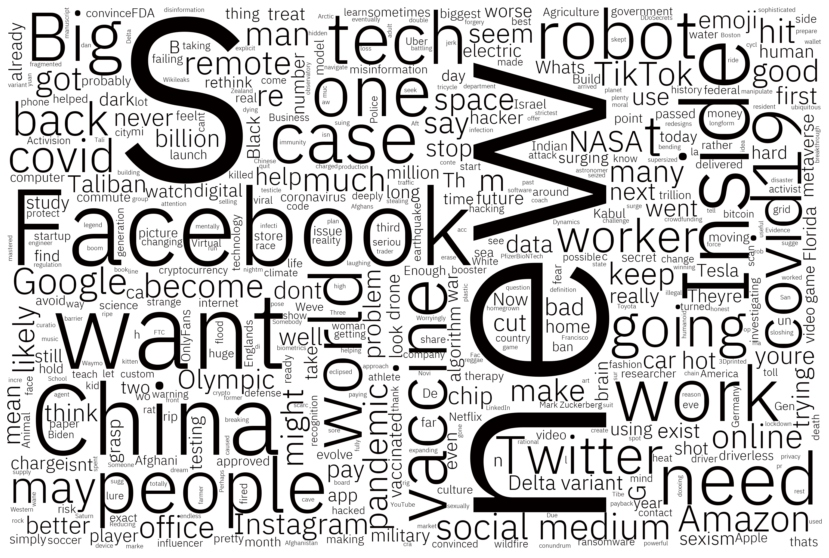

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Light.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500).generate_from_text(df['text'].to_string())

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")

In [ ]:
subset_df = df[['Date', 'text']]
subset_df.rename(colum)